# Statistical Modelling


**Read and inspect the data**

In [40]:
library(MASS)

In [41]:
data = read.csv("A1_39 (1).csv") #read data into a dataframe

In [42]:
head(data)

X,y,x
1,0.7267614,2.852152
2,6.7738556,2.471646
3,2.6402363,3.132297
4,8.5795277,2.869284
5,8.4474879,3.787900
6,20.4894539,9.257606


In [43]:
str(data)

'data.frame':	104 obs. of  3 variables:
 $ X: int  1 2 3 4 5 6 7 8 9 10 ...
 $ y: num  0.727 6.774 2.64 8.58 8.447 ...
 $ x: num  2.85 2.47 3.13 2.87 3.79 ...


In [45]:
y = data$y # response vector
x = data$x   # predictor vector
n = length(y) # the number of observations

**A straight-line regression model**

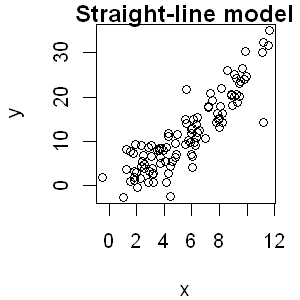

In [46]:
# set the display size to 25% x 25%
options(repr.plot.width=2.5, repr.plot.height=2.5)
# set display to 1x1 plot with margins (bottom,left,top,right)=(4,4,1,1)
par(mfrow = c(1,1), mar=c(4,4,1,1))
# plot y vs x
plot(y~x, main="Straight-line model") # adjust the main title





 **Regressions diagnostics function:**

In [47]:

regression_diagnostics <- function(y,x) {

    # set the display size to 100% x 40%
    options(repr.plot.width=10, repr.plot.height=4)
    par(mfrow = c(2,4), mar=c(4,4,3,2))

    model = lm(y~x)           # fit a straight-line model
    haty  = fitted(model)     # get fitted values, hat-y
    r     = rstandard(model)  # standardised residuals

    # Regression model plot - 
    plot(y~x, main="Straight-line model", font.main=1, cex.main=1.5) # adjust the main title
    abline(model, col=2)                                             # add a fitted regression line

    # Constance of variance: r vs x
    plot(r~x, ylab="Std residuals", 
         main="Std residuals vs x", font.main=1, cex.main=1.5)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.x = seq(min(x), max(x), length.out=20)
    lines(new.x, predict(loess(r~x), newdata=data.frame(x=new.x)), col=2) # col=2 - red colour

    # Constance of variance: r vs hat-y
    plot(r~haty, xlab="Fitted values", ylab="Std residuals",
         main="Std residuals vs Fitted", font.main=1, cex.main=1.5)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.haty = seq(min(haty),max(haty),length.out=20)
    lines(new.haty, predict(loess(r~haty), newdata=data.frame(haty=new.haty)), col=2)

    # histogram of r
    hist(r, main="Std residuals", font.main=1, cex.main=1.5)

    # built-in statistical plots
    plot(model)
    
}

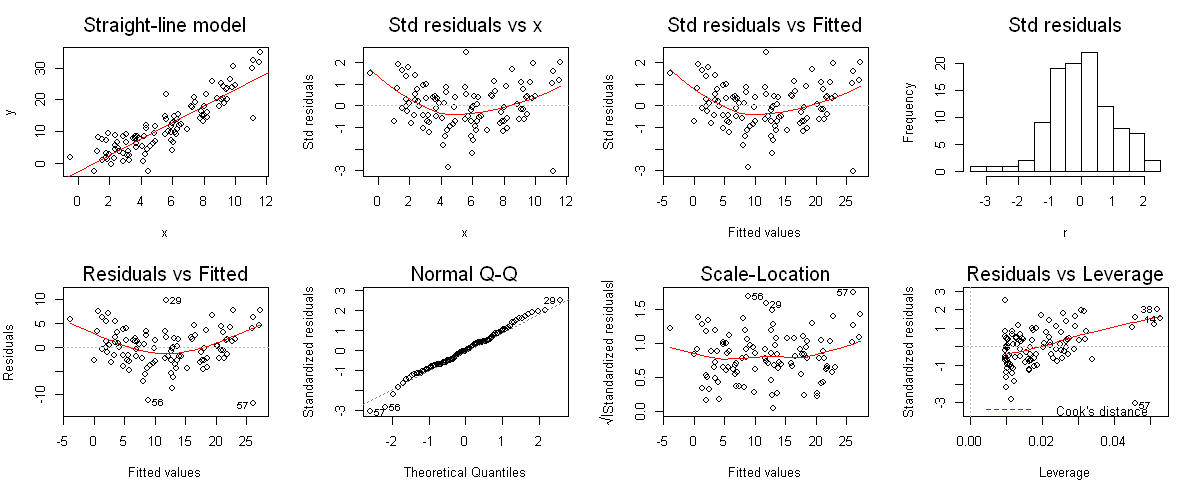

In [48]:
regression_diagnostics(y,x) 

The plots of standardised residuals indicate a clear deviation from normality assumptions,
thus the data needs to be transformed. We can see a U-shaped distribution of standardised residuals, 
thus we try transforming  𝑥→𝑥2 .


**Transformation and Regression Diagnostics**

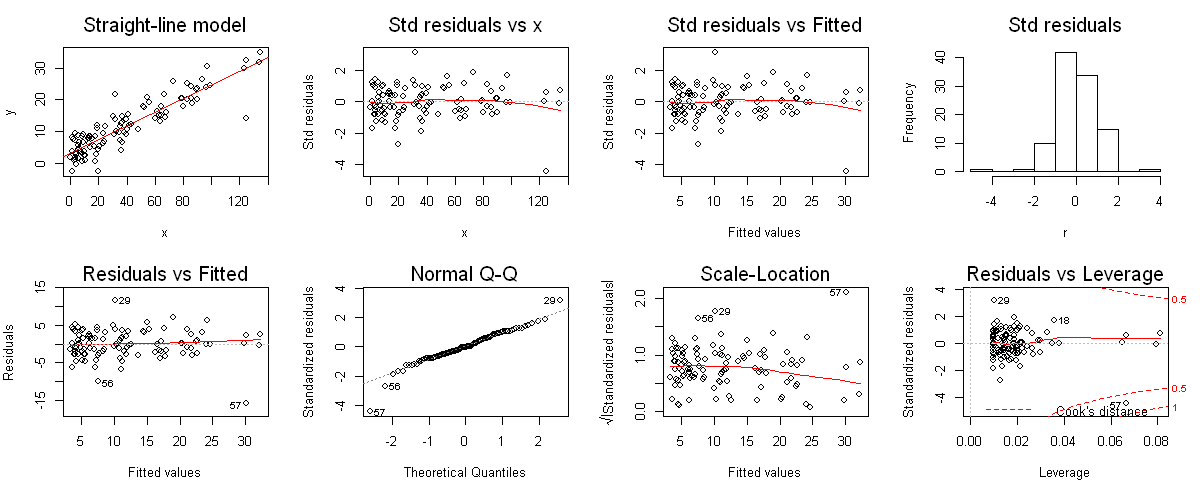

In [49]:
y2 = y
x2 = x^2
regression_diagnostics(y2,x2) 

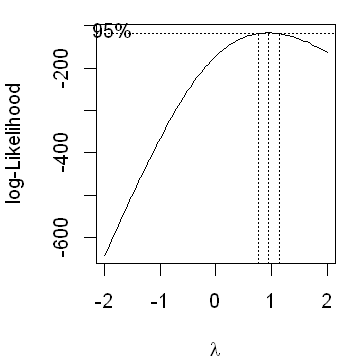

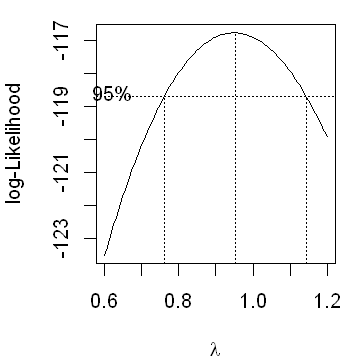

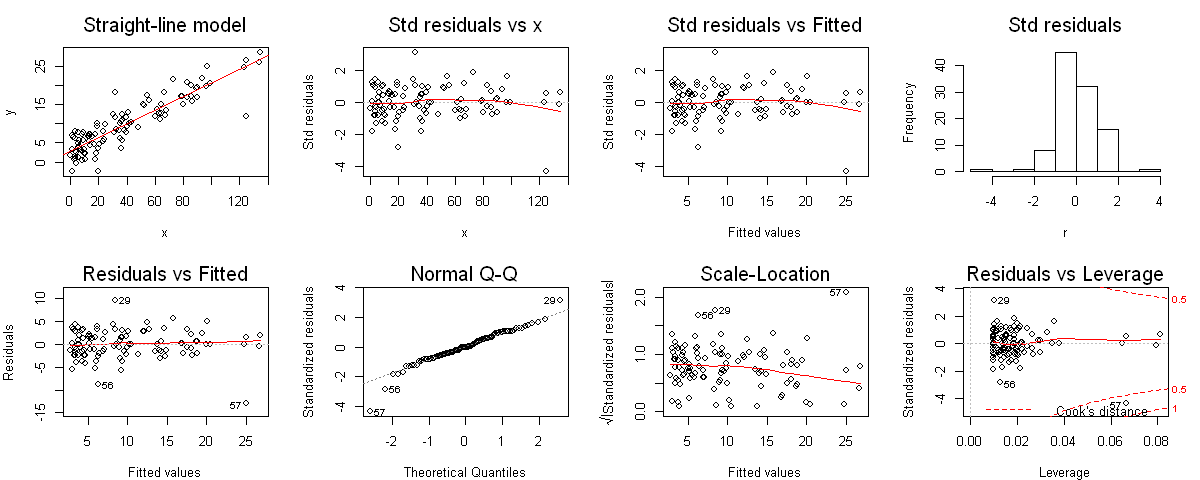

In [50]:
#add constant for boxcox plots
 xb<-x2 +3
 yb<-y2 +3


options(repr.plot.width=3, repr.plot.height=3)
par(mfrow = c(1,1), mar=c(4,4,1,1))
boxcox(yb~xb) # R tries lambda values from -2 to 2.


options(repr.plot.width=3, repr.plot.height=3)
par(mfrow = c(1,1), mar=c(4,4,1,1))
boxcox(yb~xb, lambda=seq(0.6,1.2,0.1)) # we tell R to test lambda values from 0.5 to 1.5 with step 0.1

# we zoom in lambda values close to 0.95
# The critical lambda value is about 0.95 which is close to the true value
# A 95% confidence interval is quite wide, from 0.76 to 1.15. 
# so keep as it is
# The precision of the Box-Cox method depends on the range of x-values


#don't need to transform
# Box-Cox method tells us to transform y -> y^(0.95) 
# this is very close to the true transformation

xb = xb -3
yb = (yb^0.95)-3
regression_diagnostics(yb,xb)
#plots indicate transforming makes very little difference compared to previous transformations so have decided not to transform further

**Outliers,Leverages and Cooke's Distance**

 Standardised residuals:
$$
r_i = \frac{e_i}{\sqrt{\hat\sigma^2(1-h_{ii})}} \qquad \hat\sigma^2 = \frac{1}{n-2}\sum_{i=1}^n e_i^2 \qquad e_i = y_i - \hat y_i
$$

 A popular rule to classify the $i$th point as an outlier is if $|r_i|>2$ for small- and moderate-size data sets  and if $|r_i|>4$ for large-size data sets.

- Leverage of the $i$th case:
$$
h_{ii} = \frac1n + \frac{(x_i - \bar x)^2}{s_{xx}} 
$$

 A popular rule to classify the $i$th point as a leverage point in a simple linear regression model is if
<br>
$$
h_{ii} > 2 \times \text{average}(h_{ii}) = 2 \times \frac2n = \frac4n
$$
<br> 
  A leverage point is a bad leverage point if it is also an outlier. Otherwise, it is a good leverage point.


- Cook's distance:
$$
D_i = \frac{r_i^2}{2}\cdot \frac{h_{ii}}{1-h_{ii}}
$$

In [52]:

sxx = sum((x2-mean(x2))^2)                 
sxy = sum( (x2-mean(x2))*(y2-mean(y2)) )
hatBeta1 = sxy/sxx
hatBeta0 = mean(y2) - hatBeta1*mean(x2)
haty= hatBeta0 + hatBeta1 * x2    
hatSigmaSq = sum((y2-haty)**2)/(n-2)
ei=y2-haty
Hatvalues=((1/n)+((x2-mean(x2))^2)/sxx)
residuals = y - (hatBeta0 + hatBeta1*x)  # residuals
r<-residuals/(sqrt(sum((residuals-(sum(residuals)/length(residuals)))^2)/length(residuals)))








In [53]:
# standardised residuals
residuals = y2 - (hatBeta0 + hatBeta1*x2)  # residuals
r<-residuals/(sqrt(sum((residuals-(sum(residuals)/length(residuals)))^2)/length(residuals)))
Outliers = abs(r) > 3  # outliers is a logical vector (FALSE, FALSE, TRUE, ...) indicating outliers

cat("There are", sum(Outliers), "outliers", "\n")
cat("Outlier cases are:", which(Outliers),collapse=" ")

There are 2 outliers 
Outlier cases are: 29 57  

In [54]:
#Verification of Outliers
r1<-rstandard(lm(y2~x2)) #check whether r value matches using inbuilt functions
Check_Outliers = abs(r1) > 3  # outliers is a logical vector (FALSE, FALSE, TRUE, ...) indicating outliers

cat("There are", sum(Check_Outliers), "outliers", "\n")
cat("Outlier cases are:", which(Check_Outliers),collapse=" ")

There are 2 outliers 
Outlier cases are: 29 57  

In [55]:
Hatvalues= ((1/n)+((x2-mean(x2))^2)/sxx)  # leverages

Leverages = Hatvalues > (4/n)   # leverages is a logical vector (FALSE, FALSE, TRUE, ...) indicating leverage points

cat("There are", sum(Leverages), "leverages", "\n")
cat("Leverage cases are:", which(Leverages),collapse="")

There are 5 leverages 
Leverage cases are: 38 53 57 93 104 

In [56]:
#Verification of Leverages
h2 = hatvalues(lm(y2~x2))
Check_Leverages = h2 > (4/n)   # leverages is a logical vector (FALSE, FALSE, TRUE, ...) indicating leverage points

cat("There are", sum(Check_Leverages), "leverages", "\n")
cat("Leverage cases are:", which(Check_Leverages),collapse="") 

There are 5 leverages 
Leverage cases are: 38 53 57 93 104 

In [57]:
BadLeverages  = Outliers & Leverages    # bad leverage = outlier + leverage
GoodLeverages = (!Outliers) & Leverages # good leverages = not-outlier + leverage

cat("There are", sum(BadLeverages), "bad leverages and", sum(GoodLeverages), "good leverages \n")
cat("Bad leverage cases are:", which(BadLeverages),collapse=" ", "\n")
cat("Good leverage cases are:", which(GoodLeverages),collapse=" ", "\n")

There are 1 bad leverages and 4 good leverages 
Bad leverage cases are: 57   
Good leverage cases are: 38 53 93 104   


In [58]:
D = r^2/2 * Hatvalues/(1-Hatvalues)         # Cook's distance
CooksCutOff = D > 4/(n-2)
#cooksd <- cooks.distance(lm(y ~ x)) #check if influential cases match with inbuilt functions
#influential <- as.numeric(names(cooksd)[(cooksd > (4/(length(x)-2)))]) #check if influential cases match with inbuilt functions
cat("There are", sum(CooksCutOff), "highly influential cases \n")
cat("The influential cases are:", which(CooksCutOff),collapse=" ")

There are 4 highly influential cases 
The influential cases are: 18 29 56 57  

In [59]:
advanced_regression_diagnostics <- function(y, x, OutlierCutOff = 2, big = FALSE, lloc="bottomright") {

    # set the display size to 100% x 40%
    if (big) 
    {
        options(repr.plot.width=10, repr.plot.height=20)
        par(mfrow = c(4,2), mar=c(4,4,3,2))  
    } 
    else 
    {
        options(repr.plot.width=10, repr.plot.height=4)
        par(mfrow = c(2,4), mar=c(4,4,3,2))
    }


    model = lm(y~x)           # fit a straight-line model
    haty  = fitted(model)     # get fitted values, hat-y
    r     = rstandard(model)  # standardised residuals
    h     = hatvalues(model)  # leverages
    n     = length(y)         # number of cases
    
    Outliers  = abs(r) > 3 # outliers
    Leverages = h > 4/n                # leverages
    
    D = r^2/2 * h/(1-h)        # Cook's distance
    CooksCutOff = D > 4/(n-2)  # Cook's cut-off distance
    
    # colour coding of the spcial cases
    # normal=1(black), outlier=2(red), leverage=2(green), outlier+leverage=4(blue)
    cols = 1 + Outliers + 2*Leverages  
    
    # indicator for special cases
    cases = Outliers | Leverages | CooksCutOff 

    # shape coding of CooksCutOff cases
    shapes = 1 + CooksCutOff # 1=circe, 2=triangle                   
    
    # Regression model plot
    plot(y~x, 
         main="Straight-line model", font.main=1, cex.main=1.5,  # adjust the main title
         col=cols, pch=shapes)                                   # adjust colouts and shapes
    abline(model, col=2)                                         # add a fitted regression line
    text(x[cases], y[cases], pos=4, labels=c(1:n)[cases])        # add numbers next to the special cases
    
    
    # Add legend to the regression plot if big=TRUE
    if (big)
    {
        legtext = c("Outliers", "Good Leverage", "Bad Leverage", "Cook's Cut Off")
        legend(lloc,    # position
               legend=legtext,   # legend text
               bty = "n",        # no border
               y.intersp=0.25,   # vertical spacing between legend items
               col=c(2,3,4,1),   # colours of the legend items
               pch=c(1,1,1,2)    # shape of the legend items
               )
    }
    
    # Constance of variance: r vs x
    plot(r~x, 
         ylab="Std residuals", main="Std residuals vs x", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.x = seq(min(x), max(x), length.out=20)
    lines(new.x, predict(loess(r~x), newdata=data.frame(x=new.x)), col=2) # col=2 - red colour
    text(x[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # Constance of variance: r vs hat-y
    plot(r~haty, 
         xlab="Fitted values", ylab="Std residuals",
         main="Std residuals vs Fitted", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.haty = seq(min(haty),max(haty),length.out=20)
    lines(new.haty, predict(loess(r~haty), newdata=data.frame(haty=new.haty)), col=2)
    text(haty[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # histogram of r
    hist(r, main="Std residuals", font.main=1, cex.main=1.5)

    # built-in statistical plots
    plot(model, col=cols, pch=shapes)
    
}



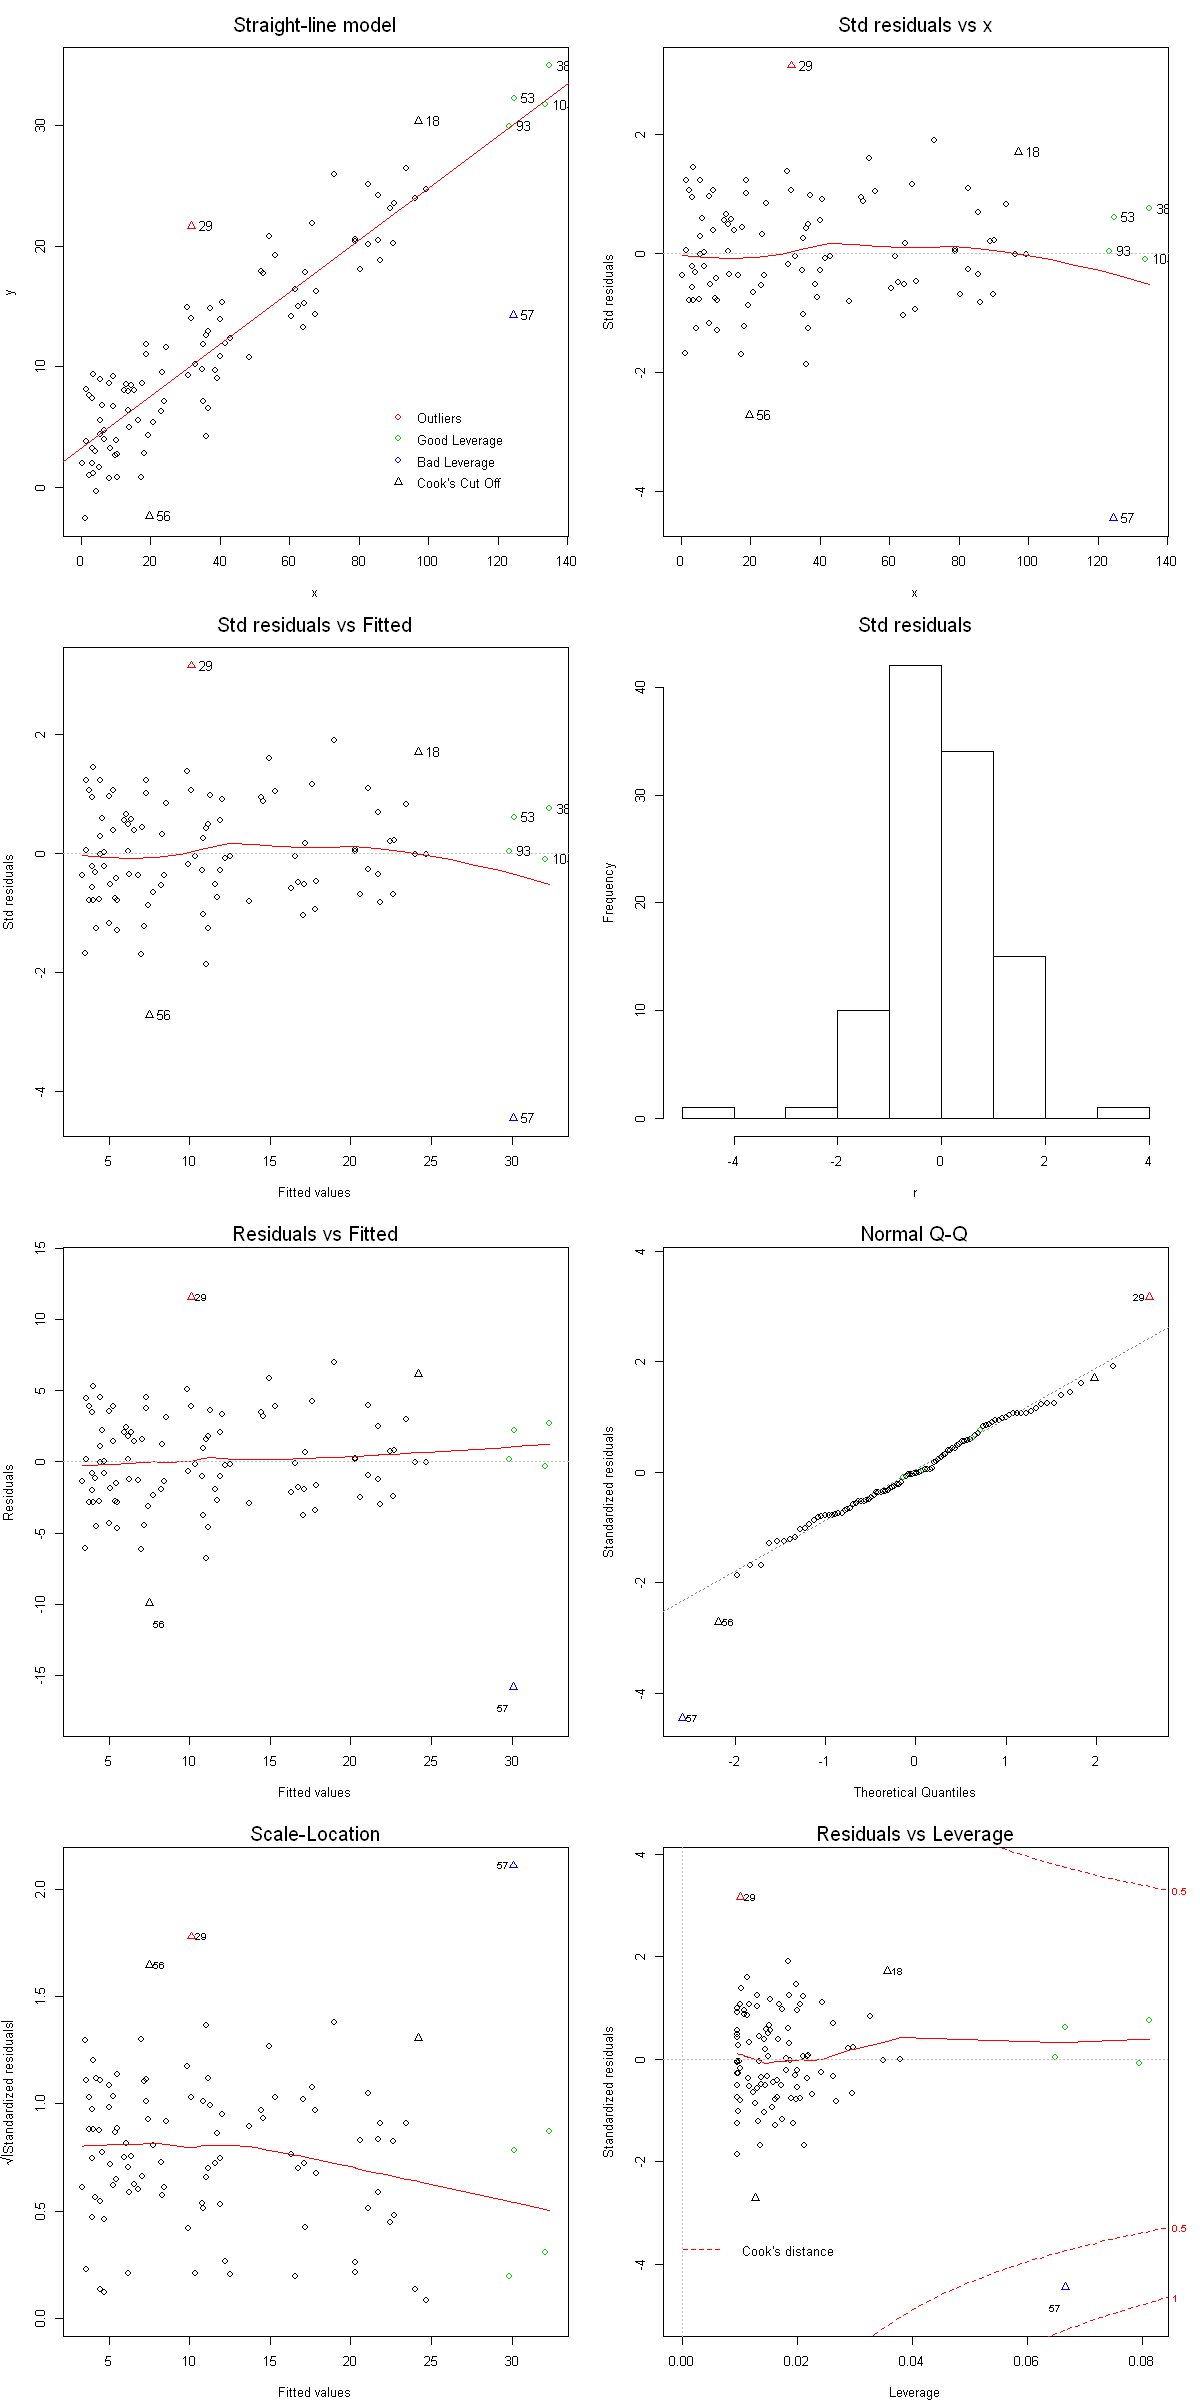

In [60]:
advanced_regression_diagnostics(y2,x2,big=1)

The case $i=57$ is bad leverage, thus we can remove it.

In [61]:
# remove bad leverage point
y3 = y2[-57]
x3 = x2[-57]
n1 = length(y3)
n1

[1] 103

In [62]:
advanced_regression_diagnostics <- function(y, x, OutlierCutOff = 2, big = FALSE, lloc="bottomright") {

    # set the display size to 100% x 40%
    if (big) 
    {
        options(repr.plot.width=10, repr.plot.height=20)
        par(mfrow = c(4,2), mar=c(4,4,3,2))  
    } 
    else 
    {
        options(repr.plot.width=10, repr.plot.height=4)
        par(mfrow = c(2,4), mar=c(4,4,3,2))
    }


    model = lm(y~x)           # fit a straight-line model
    haty  = fitted(model)     # get fitted values, hat-y
    r     = rstandard(model)  # standardised residuals
    h     = hatvalues(model)  # leverages
    n     = length(y)         # number of cases
    
    Outliers  = abs(r) > 3 # outliers
    Leverages = h > 4/n                # leverages
    
    D = r^2/2 * h/(1-h)        # Cook's distance
    CooksCutOff = D > 4/(n-2)  # Cook's cut-off distance
    
    # colour coding of the spcial cases
    # normal=1(black), outlier=2(red), leverage=2(green), outlier+leverage=4(blue)
    cols = 1 + Outliers + 2*Leverages  
    
    # indicator for special cases
    cases = Outliers | Leverages | CooksCutOff 

    # shape coding of CooksCutOff cases
    shapes = 1 + CooksCutOff # 1=circe, 2=triangle                   
    
    # Regression model plot
    plot(y~x, 
         main="Straight-line model", font.main=1, cex.main=1.5,  # adjust the main title
         col=cols, pch=shapes)                                   # adjust colouts and shapes
    abline(model, col=2)                                         # add a fitted regression line
    text(x[cases], y[cases], pos=4, labels=c(1:n)[cases])        # add numbers next to the special cases
    
    
    # Add legend to the regression plot if big=TRUE
    if (big)
    {
        legtext = c("Outliers", "Good Leverage", "Bad Leverage", "Cook's Cut Off")
        legend(lloc,    # position
               legend=legtext,   # legend text
               bty = "n",        # no border
               y.intersp=0.25,   # vertical spacing between legend items
               col=c(2,3,4,1),   # colours of the legend items
               pch=c(1,1,1,2)    # shape of the legend items
               )
    }
    
    # Constance of variance: r vs x
    plot(r~x, 
         ylab="Std residuals", main="Std residuals vs x", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.x = seq(min(x), max(x), length.out=20)
    lines(new.x, predict(loess(r~x), newdata=data.frame(x=new.x)), col=2) # col=2 - red colour
    text(x[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # Constance of variance: r vs hat-y
    plot(r~haty, 
         xlab="Fitted values", ylab="Std residuals",
         main="Std residuals vs Fitted", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.haty = seq(min(haty),max(haty),length.out=20)
    lines(new.haty, predict(loess(r~haty), newdata=data.frame(haty=new.haty)), col=2)
    text(haty[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # histogram of r
    hist(r, main="Std residuals", font.main=1, cex.main=1.5)

    # built-in statistical plots
    plot(model, col=cols, pch=shapes)
    
}



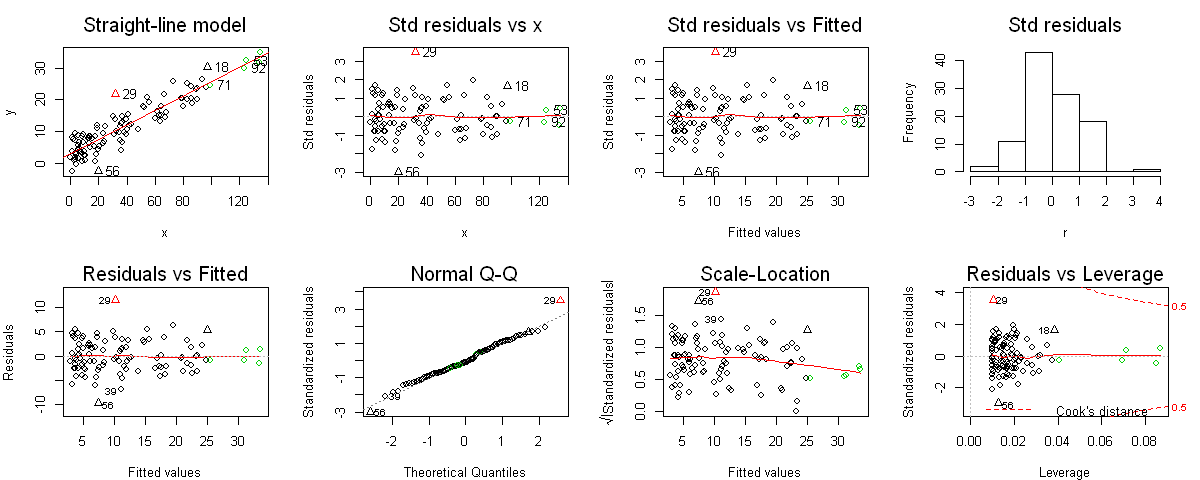

In [63]:
# "big" regression diagnostics 
advanced_regression_diagnostics(y3,x3)

The case $i=29$ is an outlier and has a high leverage, thus we can remove it as well.

In [64]:
# remove case 29: an influential outlier
y4 = y3[-29]
x4 = x3[-29]
n2 = length(y4)
n2

[1] 102

In [65]:
advanced_regression_diagnostics <- function(y, x, OutlierCutOff = 2, big = FALSE, lloc="bottomright") {

    # set the display size to 100% x 40%
    if (big) 
    {
        options(repr.plot.width=10, repr.plot.height=20)
        par(mfrow = c(4,2), mar=c(4,4,3,2))  
    } 
    else 
    {
        options(repr.plot.width=10, repr.plot.height=4)
        par(mfrow = c(2,4), mar=c(4,4,3,2))
    }


    model = lm(y~x)           # fit a straight-line model
    haty  = fitted(model)     # get fitted values, hat-y
    r     = rstandard(model)  # standardised residuals
    h     = hatvalues(model)  # leverages
    n     = length(y)         # number of cases
    
    Outliers  = abs(r) > 3 # outliers
    Leverages = h > 4/n                # leverages
    
    D = r^2/2 * h/(1-h)        # Cook's distance
    CooksCutOff = D > 4/(n-2)  # Cook's cut-off distance
    
    # colour coding of the spcial cases
    # normal=1(black), outlier=2(red), leverage=2(green), outlier+leverage=4(blue)
    cols = 1 + Outliers + 2*Leverages  
    
    # indicator for special cases
    cases = Outliers | Leverages | CooksCutOff 

    # shape coding of CooksCutOff cases
    shapes = 1 + CooksCutOff # 1=circe, 2=triangle                   
    
    # Regression model plot
    plot(y~x, 
         main="Straight-line model", font.main=1, cex.main=1.5,  # adjust the main title
         col=cols, pch=shapes)                                   # adjust colouts and shapes
    abline(model, col=2)                                         # add a fitted regression line
    text(x[cases], y[cases], pos=4, labels=c(1:n)[cases])        # add numbers next to the special cases
    
    
    # Add legend to the regression plot if big=TRUE
    if (big)
    {
        legtext = c("Outliers", "Good Leverage", "Bad Leverage", "Cook's Cut Off")
        legend(lloc,    # position
               legend=legtext,   # legend text
               bty = "n",        # no border
               y.intersp=0.25,   # vertical spacing between legend items
               col=c(2,3,4,1),   # colours of the legend items
               pch=c(1,1,1,2)    # shape of the legend items
               )
    }
    
    # Constance of variance: r vs x
    plot(r~x, 
         ylab="Std residuals", main="Std residuals vs x", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.x = seq(min(x), max(x), length.out=20)
    lines(new.x, predict(loess(r~x), newdata=data.frame(x=new.x)), col=2) # col=2 - red colour
    text(x[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # Constance of variance: r vs hat-y
    plot(r~haty, 
         xlab="Fitted values", ylab="Std residuals",
         main="Std residuals vs Fitted", font.main=1, cex.main=1.5,
         col=cols, pch=shapes)
    abline(h=0, lty=3, col=8)
    # the next two lines add a trend-line to the plot - loess fit - locally estimated scatterplot smoothing
    new.haty = seq(min(haty),max(haty),length.out=20)
    lines(new.haty, predict(loess(r~haty), newdata=data.frame(haty=new.haty)), col=2)
    text(haty[cases], r[cases], pos=4, labels=c(1:n)[cases]) 

    # histogram of r
    hist(r, main="Std residuals", font.main=1, cex.main=1.5)

    # built-in statistical plots
    plot(model, col=cols, pch=shapes)
    
}



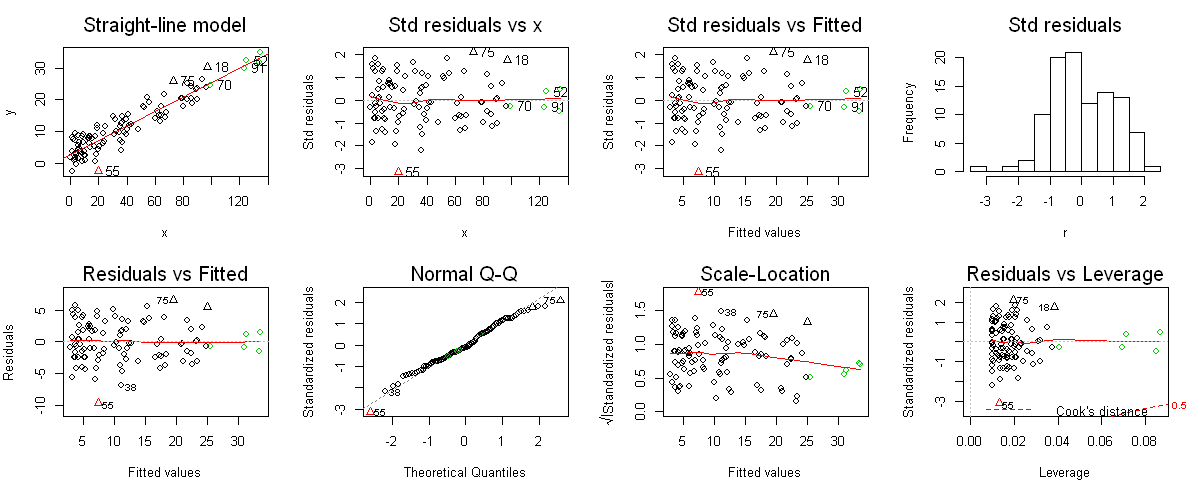

In [66]:
advanced_regression_diagnostics(y4,x4)

Diganostics plots look better

Standardised errors are normally distirbuted - there are no obvious patterns that could "break" normality

Histogram is not much bell-shaped, but it is not too much asymetric, which is reasonable for small- and medium-sized data sets

Normall Q-Q plot is close to a straight line, which is what we want to have.

Scale-location does not show any particular patter that would indicate any issues with the model.

This plot shows if residuals are spread equally along the ranges of predictors. 

This is how you can check the assumption of equal variance (homoscedasticity).

We see a horizontal line with equally (randomly) spread points so this is good

**Simple linear regression analysis**

 Testing $95\%$ confidence interval for the slope of the regression model using

$$ 
{\rm CI(\beta_1)} = \big[ \hat\beta_1 - t_{\alpha/2,\, n-2}\cdot {\rm se}(\hat\beta_1), \hat\beta_1 + t_{\alpha/2,\, n-2}\cdot {\rm se}(\hat\beta_1) \big]
$$
where
$$
{\rm se}(\hat\beta_1) = \sqrt{\hat\sigma^2/s_{xx}} ,\qquad \hat\sigma^2 = \frac{1}{n-2}\sum_{i=1}^n (y_i - \hat y_i)^2.
$$
Use ``qt(1-0.05/2, n-2)`` to get the critical t-value, $t_{\alpha/2,\, n-2}$.



In [67]:
sxx = sum( (x4-mean(x4))^2 )
sxy = sum( (x4-mean(x4))*(y4-mean(y4)) )
n2<-length(x4)

hatBeta1 = sxy/sxx                      # estimated slope
hatBeta0 = mean(y4) - hatBeta1*mean(x4)   # estimated intercept

sprintf("intercept = %.2f, slope = %.2f", hatBeta0, hatBeta1)


[1] "intercept = 2.85, slope = 0.23"

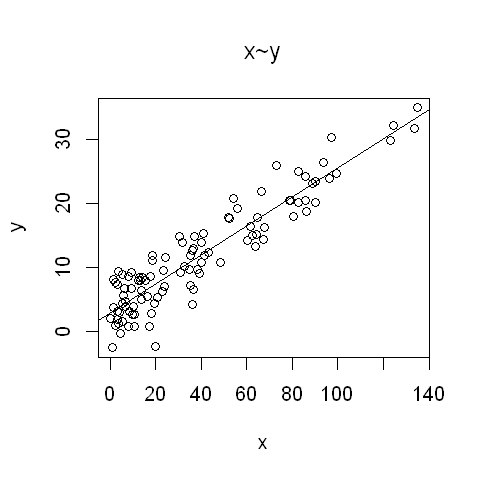

In [68]:
# scatter plot + regression line
options(repr.plot.width=4, repr.plot.height=4) # sets plotting size
plot(x4, y4, main="Scatter plot and regression line for x~y", xlab="x", ylab="y", font.main=1)
abline(a=hatBeta0, b=hatBeta1)

In [69]:
haty       = hatBeta0 + hatBeta1 * x4    # find fitted values from the regression line
hatSigmaSq = sum( (y4-haty)**2 ) / (n2-2)  # estimated variance hat-sigma-squared
seBeta1    = sqrt( hatSigmaSq/sxx )      # estimated standard error of beta-1
seBeta0    = sqrt( hatSigmaSq * (1/n + mean(x4)^2/sxx) ) # estimated standard error of beta-0
tcrit      = qt(1-0.05/2, n2-2)           # critical t-value for 100% - 5%/2 = 97.5%
CI1min      = hatBeta1 - tcrit*seBeta1     # intercept lower limit of CI
CI1max      = hatBeta1 + tcrit*seBeta1     # intercept upper limit of CI
CI0min      = hatBeta0 - tcrit*seBeta0     # slope lower limit of CI
CI0max      = hatBeta0 + tcrit*seBeta0     # slope upper limit of CI

sprintf("A 95%% CI for the slope is [%.2f, %.2f]", CI1min, CI1max)

[1] "A 95% CI for the slope is [0.21, 0.25]"

 Assuming $\alpha=5\%$, test the null hypothesis $H_0 : \beta_0 = 0$ against a two-sided alternative.
Interpret your result. The test statistic is

$$
T = \frac{\hat\beta_0 - \beta^*_0}{{\rm se}(\hat\beta_0)} \sim t_{n-2}
$$
where
$$
{\rm se}(\hat\beta_0) = \sqrt{\hat\sigma^2(1/n + \bar x^2 / s_{xx})}
$$

In [70]:
t0cal   = (hatBeta0 - 0) / seBeta0                 # calculated t-value for beta-0
t1cal   = (hatBeta1 - 0) / seBeta1                     # calculated t-value for beta-1

sprintf("The calculated t-value for is %.2f. The critical t-value is %.2f", t0cal, tcrit)
#Since  |𝑡𝑐𝑎𝑙|>𝑡𝑐𝑟𝑖𝑡 , we reject the null hypothesis.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "The calculated t-value for is 6.10. The critical t-value is 1.98"

 Since $|t_{cal}|>t_{crit}$, we reject the null hypothesis

 Compute the total sum of squares, $SS_T$, the regression sum of squares, $SS_R$, and the residual sum of squares, $SS_E$:

$$
SS_T = \sum_{i=1}^n(y_i-\bar y)^2 \qquad
SS_R = \sum_{i=1}^n(\hat y_i-\bar y)^2 \qquad
SS_E = \sum_{i=1}^n(y_i-\hat y_i)^2
$$

where $\hat y_i = \hat\beta_0 + \hat\beta_1 x_i$ are fitted values. Then verify the analysis of variance identity

$$
SS_T = SS_R + SS_E
$$


In [71]:
SST = sum( (y4 - mean(y4))^2 )     # total sum of squares = syy
SSR = sum( (haty - mean(y4))^2 )  # regression sum of squares
SSE = sum( (y4 - haty)^2 )        # residual sum of squares

sprintf("SST = %.2f, SSR = %.2f, SSE = %.2f", SST, SSR, SSE)

[1] "SST = 7147.64, SSR = 6169.28, SSE = 978.36"

In [72]:
SST - SSR - SSE # verify the analysis of variance identity, SST = SSR + SSE

[1] -1.364242e-12

In [73]:
all.equal(SST, SSR + SSE)

[1] TRUE

In [74]:
MSR   = SSR / 1             # mean regression sum of squares
MSE   = SSE / (n2-2)         # mean residual sum of squares
Fcal  = MSR/MSE             # calculated variance ratio, i.e. calculated F-value
Fcrit = qf(1-0.05, 1, n2-1)  # critical t-value

sprintf("MSR = %.2f, MSE = %.2f, F-cal = %.2f, F-crit = %.2f", MSR, MSE, Fcal, Fcrit)

[1] "MSR = 6169.28, MSE = 9.78, F-cal = 630.57, F-crit = 3.94"

Analysis of variance table

| Source of Variation | d.o.f. | SS       | MS       | F     |
|:--------------------|-------:|---------:|---------:|------:|
| Regression          |   1    | 6169.28  | 6169.28  |630.57 |
| Residual            |   100  | 978.36   |  9.78    |       |
| Total               |   101  | 7147.64  |          |       |

In [75]:
anova_df = data.frame("Source of Variation" = c("Regression","Residual","Total"),
                      "d.o.f." = c(1,100,101),
                      SS = c(SSR,SSE,SST),
                      MS = c(MSR,MSE,NA),
                      F  = c(Fcal,NA,NA)
                     )
anova_df

Source.of.Variation,d.o.f.,SS,MS,F
Regression,1,6169.2766,6169.276567,630.5725
Residual,100,978.3612,9.783612,NA
Total,101,7147.6377,NA,NA


Since $F_{cal} > F_{crit}$, we concluce that regression is significant, i.e. we reject the null hypothesis $H_0 : \beta_1 = 0$.

 Compute the coefficient of determination
$$
R^2 = 1 - \frac{SS_E}{SS_T}
$$


In [76]:
#R-squared value
R2 = 1 - SSE/SST
#Adjusted R value
AR2 = 1-((1-R2)*(n2-1))/(n2-1-1)

paste("R-squared value:", round(R2,4), ", Adjusted R-squared:", round(AR2,4),", F-statistic:", round(Fcal,1))

[1] "R-squared value: 0.8631 , Adjusted R-squared: 0.8618 , F-statistic: 630.6"

In [77]:
# replace numbers with your variables, e.g. hatBeta0, hatBeta1, Beta0.CImin, Beta0.CImax, etc...
table.summary = data.frame(row.names=c("Intercept","Slope"),
                           estimate=c(hatBeta0,hatBeta1), 
                           lwb=c(CI0min,CI1min),    
                           upb=c(CI0max,CI1max),   
                           error=c(seBeta0,seBeta1 ),   
                           tcal=c(t0cal,t1cal), 
                           hypo=c(0,1)                    # 0=Reject, 1=Accept
)

# you need to rename columns 
names(table.summary) = c("Estimate", "Lower bound", "Upper bound", "Std. error", 
                         "t-value",  "Null hypothesis") 
table.summary
# round numerical values
round(table.summary,3) 

#p value <0.005 there fore statistically signif reject null H,
#The low F-value graph shows a case where the group means are close together (low variability) relative to the variability within each group. The high F-value graph shows a case where the variability of group means is large relative to the within group variability. In order to reject the null hypothesis that the group means are equal, we need a high F-value.
#################################

,Estimate,Lower bound,Upper bound,Std. error,t-value,Null hypothesis
Intercept,2.8497504,1.9233054,3.7761954,0.466964866,6.102708,0
Slope,0.2275563,0.2095776,0.2455349,0.009061943,25.111203,1


,Estimate,Lower bound,Upper bound,Std. error,t-value,Null hypothesis
Intercept,2.850,1.923,3.776,0.467,6.103,0
Slope,0.228,0.210,0.246,0.009,25.111,1


In [78]:
text <- paste("R-squared value:", round(R2,4), ", Adjusted R-squared:", round(AR2,4),", F-statistic:", round(Fcal,1))
text

[1] "R-squared value: 0.8631 , Adjusted R-squared: 0.8618 , F-statistic: 630.6"

**Verification of Results** 

In [79]:
#compare with in-built functions
lm<-lm(y4 ~ x4)
summary(lm)
confint(lm)
res.aov <- aov(x4 ~ y4)
summary(res.aov)


Call:
lm(formula = y4 ~ x4)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7314 -2.1788 -0.3454  2.3209  6.4904 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.849750   0.468936   6.077 2.24e-08 ***
x4          0.227556   0.009062  25.111  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.128 on 100 degrees of freedom
Multiple R-squared:  0.8631,	Adjusted R-squared:  0.8618 
F-statistic: 630.6 on 1 and 100 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),1.9193952,3.7801056
x4,0.2095776,0.2455349


             Df Sum Sq Mean Sq F value Pr(>F)    
y4            1 102832  102832   630.6 <2e-16 ***
Residuals   100  16308     163                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [80]:
# round numerical values
title <- paste("Linear Regression:y4~x4")
table <- round(table.summary,3)
table <- list()
table[[1]] <- title
table[[2]] <- table.summary
table[[3]] <- text
table



,Estimate,Lower bound,Upper bound,Std. error,t-value,Null hypothesis
Intercept,2.8497504,1.9233054,3.7761954,0.466964866,6.102708,0
Slope,0.2275563,0.2095776,0.2455349,0.009061943,25.111203,1


**Conclusion**

R^2	=	coefficient of determination. R2 is 0.86, which is very high, this means the model explains 86% of the variation in the response variable around the mean.  



The low F-value graph shows a case where the means of the two groups are close together (low variability) relative to the variability within each group. 
The high F-value graph shows a case where the means of the two groups show higher variability relative to each other. In this case there is a high F-value, therefore, we reject null hypothesis.


Standard error show absolute measure of the typical distance that the data points fall from the regression line. The standard error for the slope is very low which indicates less spread and therefore more true representations of population mean.


Approximately 95% of the observations fall within 2 X 0.0091 of the regression from the regression line,and within 2 x 0.47 of the intercept


T-value for intercept and slope are high. The greater the magnitude of T-value, the greater the evidence against the null hypothesis, therefore we can reject null hypothesis


P value is <0.005 and therefore is highly statistically significant so we can reject null hypothesis. 

